In [30]:
import os
import numpy as np
import lmfit
import csv
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

In [36]:
# helper functions

def sinusoid(x, a, b, c):
    return a * np.sin(b * x + c)

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]

def swap_lr(series):
    for l_key in series:
        if (l_key[0] == 'l'):
            r_key = 'right' + l_key[4:]
            temp = series[l_key]
            series[l_key] = series[r_key]
            series[r_key] = temp
    return series

def write_csv(filename, series):
    with open('..\\time_series\\temporally_normalized\\' + filename, 'w') as csv_out:
        writer = csv.writer(csv_out)
        writer.writerow(series.keys())
        writer.writerows(zip(*series.values()))

def regress_sine_wave(x, y):
    model = lmfit.models.SineModel()
    y = savgol_filter(y, window_length=11, polyorder=3)
    y -= np.mean(y)
    y /= (max(y) - min(y))
    params = model.guess(y, x)
    fit = model.fit(y, params, x=x)

    lmfit_amp = fit.params['amplitude'].value
    lmfit_omega = fit.params['frequency'].value
    lmfit_shift = fit.params['shift'].value

    return [lmfit_amp, lmfit_omega, lmfit_shift]

def get_period_and_offset(params):
    amp = params[0]
    omega = params[1]
    shift = params[2]
    period = 2 * (np.pi) / omega

    offset = (0.5 * np.pi / float(omega)) - (float(shift) / float(omega))

    if (amp < 0.0):
        offset -= (np.pi) / (float(omega))

    while (offset < 0.0): 
        offset += period

    while (offset > period):
        offset -= period

    return [period, offset]

In [32]:
''' LAYOUT OF TEMPORAL OPTIMIZATION PIPELINE

define lists for offset and period

[1] find correct sides, offsets, and periods

for each scale normalized series:

    load the series

    regress left and right heel_y's, storing left and right params

    save period as 2pi / omega
    save offset as (0.5 * pi / omega) - (shift/omega)
        add period until offset is greater than 0
        subtract period until offset less than 2pi
    choose side with lower offset

[2] trim examples

find minimum period

for each scale normalized file:
    if foot and entryside mismatch:
        swap all L-R coords (helper function)

    find number of examples: min (((total frames - offset) / period), 3)
    find step size: current_period / min_period

    define a new series and step through at the step size, picking values to put in the normalized list

    for each number of examples:
        define a new series and append all the stepped frame values 

'''

" LAYOUT OF TEMPORAL OPTIMIZATION PIPELINE\n\ndefine lists for offset and period\n\n[1] find correct sides, offsets, and periods\n\nfor each scale normalized series:\n\n    load the series\n\n    regress left and right heel_y's, storing left and right params\n\n    save period as 2pi / omega\n    save offset as (0.5 * pi / omega) - (shift/omega)\n        add period until offset is greater than 0\n        subtract period until offset less than 2pi\n    choose side with lower offset\n\n[2] trim examples\n\nfind minimum period\n\nfor each scale normalized file:\n    if foot and entryside mismatch:\n        swap all L-R coords (helper function)\n\n    find number of examples: min (((total frames - offset) / period), 3)\n    find step size: current_period / min_period\n\n    define a new series and step through at the step size, picking values to put in the normalized list\n\n    for each number of examples:\n        define a new series and append all the stepped frame values \n\n"

In [33]:
# [1] Finding periods and offsets

scale_normalized_dir = '..\\time_series\\scale_normalized\\'
scale_normalized_files = os.listdir(scale_normalized_dir)

periods = {}
offsets = {}
sides = {}

for file in scale_normalized_files:
    series, num_frames = load_series(scale_normalized_dir + file)

    X = np.arange(0, num_frames)

    l_params = regress_sine_wave(X, series['left_heel_y'])
    r_params = regress_sine_wave(X, series['right_heel_y'])

    l_period_offset = get_period_and_offset(l_params)
    r_period_offset = get_period_and_offset(r_params)

    '''
    PLOTTING

    fig, ax = plt.subplots(2, figsize=(20, 10))
    ax[0].plot(X, series['left_heel_y'])
    ax[0].plot(X, sinusoid(X, *l_params))
    ax[0].axvline(l_period_offset[1], c='r')
    ax[0].axvline(np.sum(l_period_offset), c='b')

    ax[1].plot(X, series['right_heel_y'])
    ax[1].plot(X, sinusoid(X, *r_params))
    ax[1].axvline(r_period_offset[1], c='r')
    ax[1].axvline(np.sum(r_period_offset), c='b') 
    
    '''

    if (l_period_offset[1] < r_period_offset[1]): # if the left offset is smaller
        periods[file] = l_period_offset[0]
        offsets[file] = l_period_offset[1]
        sides[file] = 'L'
    else:
        periods[file] = r_period_offset[0]
        offsets[file] = r_period_offset[1]
        sides[file] = 'R'

period_list = []
for key in periods:
    period_list.append(periods[key])

print(min(period_list))

print(periods)
print(offsets)
print(sides)

7.258037800885531
{'SR-O0-F0-B2-S7-L1-R-0059.csv': 21.895829527165585, 'SR-O0-F0-B6-S4-L7-R-0051.csv': 22.399868888307008, 'SR-O0-F3-B0-S1-L8-R-0036.csv': 22.349622666426608, 'SR-O0-F4-B0-S2-L2-R-0007.csv': 21.290065932242534, 'SR-O0-F4-B0-S2-L2-R-0009.csv': 20.68372881683032, 'SR-O0-F4-B0-S4-L7-R-0003.csv': 20.90333442270948, 'SR-O0-F5-B0-S2-L8-L-0002.csv': 22.249412333940672, 'SR-O0-F6-B0-S1-L7-R-0034.csv': 24.27532206357557, 'SR-O0-F6-B0-S2-L8-L-0033.csv': 24.885233754238854, 'SR-O0-F6-B0-S2-L9-L-0008.csv': 20.881344462791244, 'SR-O0-F8-B0-S4-L3-R-0001.csv': 20.745708596251117, 'SR-O0-F9-B0-S4-L3-R-0005.csv': 20.28936521231477, 'SR-O1-F0-B5-S5-L7-L-0050.csv': 11.15759453623121, 'SR-O2-F0-B3-S3-L2-L-0026.csv': 24.796081300862983, 'SR-O2-F0-B5-S3-L1-R-0057.csv': 22.20316934862861, 'SR-O2-F3-B0-S3-L5-R-0072.csv': 23.9121092723036, 'SR-O2-F5-B0-S3-L7-R-0063.csv': 23.13023179017117, 'SR-O3-F0-B5-S1-L4-L-0054.csv': 23.430862976298783, 'SR-O3-F0-B7-S2-L9-L-0024.csv': 24.62501642515268, 'SR

WS-O1-F0-B5-S2-L0-L-0047.csv


(array([ 2.,  2.,  3.,  2.,  2.,  2.,  3.,  5., 15., 21., 17.,  8.,  7.,
        14., 20., 21., 18., 14., 13.,  9., 10.,  3.,  0.,  1.,  2.,  0.,
         0.,  1.,  0.,  2.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  3.,
         0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  2.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

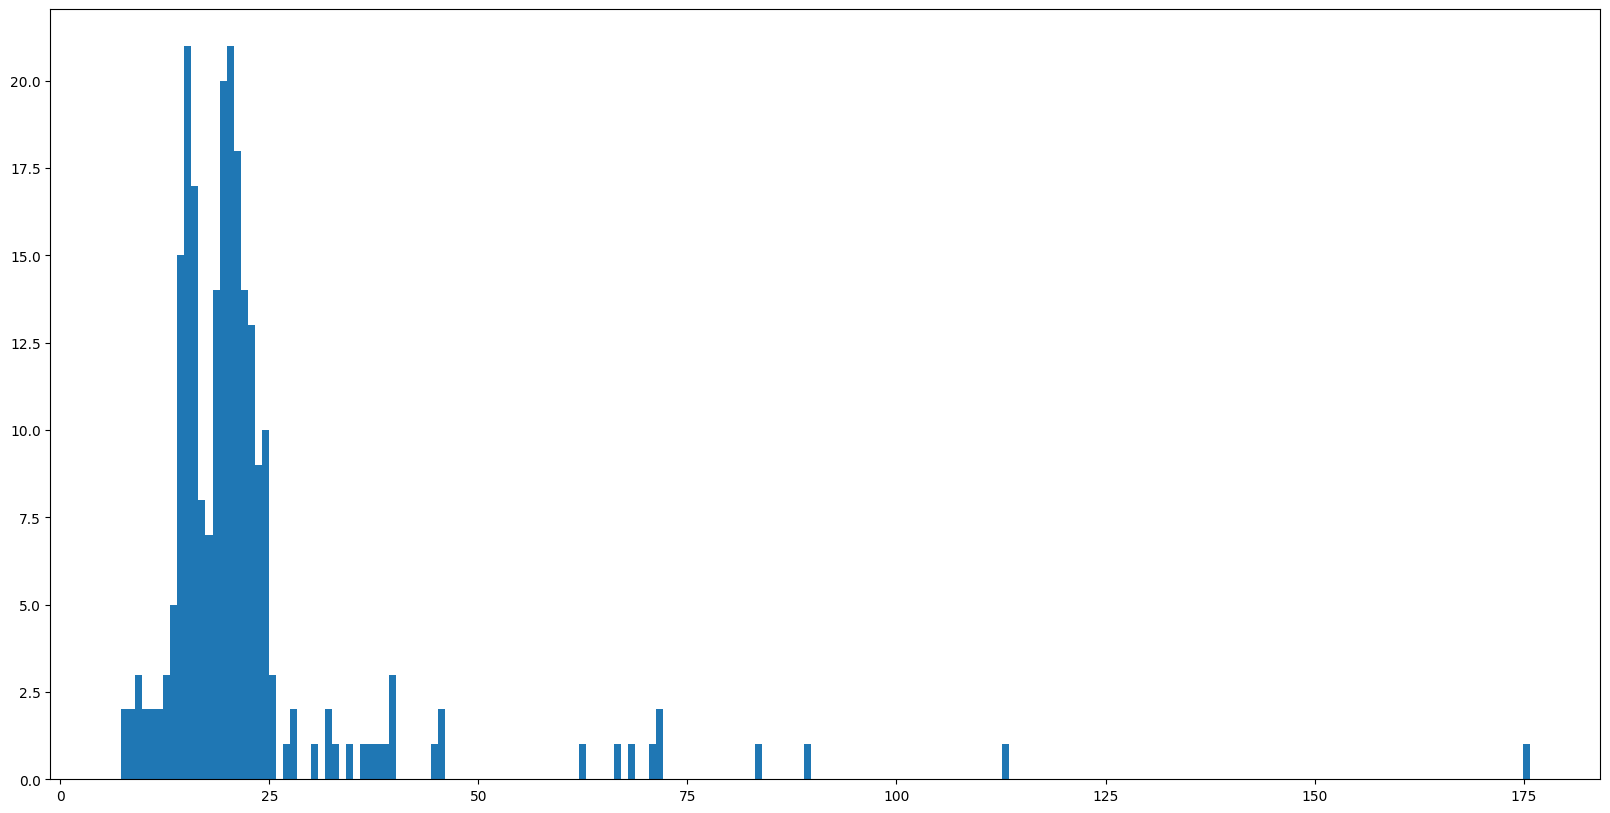

In [34]:
# visualizing period data

l = []
for key in periods:
    if periods[key] > 150:
        print(key)
    l.append(periods[key])
fig = plt.figure(figsize=(20, 10))
plt.hist(l, bins=200)

In [37]:
# [2] trimming and reducing series

min_period = int(min(period_list))

fig = plt.figure(figsize=(20, 5))

for key in periods:

    series, num_frames = load_series(scale_normalized_dir + key)

    period = periods[key]
    offset = offsets[key]
    side = sides[key]

    samples = np.asarray(np.linspace(offset, offset + period, dtype=float, num=min_period).round(decimals=0), dtype=int)

    if (side != key[18]):
        series = swap_lr(series)

    new_series = {
            'left_shoulder_x' : [], 'left_shoulder_y' : [], 'left_shoulder_z' : [], 'left_shoulder_v' : [],
            'right_shoulder_x' : [], 'right_shoulder_y' : [], 'right_shoulder_z' : [], 'right_shoulder_v' : [],
            'left_elbow_x' : [], 'left_elbow_y' : [], 'left_elbow_z' : [], 'left_elbow_v' : [],
            'right_elbow_x' : [], 'right_elbow_y' : [], 'right_elbow_z' : [], 'right_elbow_v' : [],
            'left_wrist_x' : [], 'left_wrist_y' : [], 'left_wrist_z' : [], 'left_wrist_v' : [],
            'right_wrist_x' : [], 'right_wrist_y' : [], 'right_wrist_z' : [], 'right_wrist_v' : [],
            'left_hip_x' : [], 'left_hip_y' : [], 'left_hip_z' : [], 'left_hip_v' : [],
            'right_hip_x' : [], 'right_hip_y' : [], 'right_hip_z' : [], 'right_hip_v' : [],
            'left_knee_x' : [], 'left_knee_y' : [], 'left_knee_z' : [], 'left_knee_v' : [],
            'right_knee_x' : [], 'right_knee_y' : [], 'right_knee_z' : [], 'right_knee_v' : [],
            'left_ankle_x' : [], 'left_ankle_y' : [], 'left_ankle_z' : [], 'left_ankle_v' : [],
            'right_ankle_x' : [], 'right_ankle_y' : [], 'right_ankle_z' : [], 'right_ankle_v' : [],
            'left_heel_x' : [], 'left_heel_y' : [], 'left_heel_z' : [], 'left_heel_v' : [],
            'right_heel_x' : [], 'right_heel_y' : [], 'right_heel_z' : [], 'right_heel_v' : [],
            'left_foot_index_x' : [], 'left_foot_index_y' : [], 'left_foot_index_z' : [], 'left_foot_index_v' : [],
            'right_foot_index_x' : [], 'right_foot_index_y' : [], 'right_foot_index_z' : [], 'right_foot_index_v' : []
        }
    
    if (num_frames <= samples[-1]):
        print('FAILED TO NORMALIZE ' + key)
        continue

    for point in series:
        for frame in samples:
            new_series[point].append(series[point][frame])
    
    write_csv(key, new_series)


    

FAILED TO NORMALIZE SR-O5-F0-B4-S3-L2-L-0060.csv
FAILED TO NORMALIZE SR-O9-F8-B0-S7-L2-L-0041.csv
FAILED TO NORMALIZE SR-O9-F9-B0-S5-L8-L-0043.csv
FAILED TO NORMALIZE WS-O1-F0-B0-S3-L0-L-0131.csv
FAILED TO NORMALIZE WS-O1-F0-B3-S4-L6-R-0179.csv
FAILED TO NORMALIZE WS-O3-F0-B4-S3-L5-L-0025.csv
FAILED TO NORMALIZE WS-O4-F0-B4-S7-L0-L-0183.csv


<Figure size 2000x500 with 0 Axes>